# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Pulkit Jain, pj2313

Member 2: Greg Kocher, gk2500

Member 3: Ratheet Pandya, rp2707

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [72]:
DEBUG = True#False#True
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda_L2=.0, \
                 reg_lambda_L1=.0, K_iters_alpha_drop=500, gamma=.90, \
                 do_reflection=False, standard_scaling=False):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda_L2: regularization parameter. Only required in part 2 of the assignment
        """
        #np.random.seed(1)
        
        self.parameters = {
            'layerDimensions' : layer_dimensions
        }
        self.num_layers = len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda_L2 = reg_lambda_L2
        self.reg_lambda_L1 = reg_lambda_L1
        
        #Stepwise exponentially decaying learning rate:
        #every K iterations, learning rate alpha is multiplied
        #by 0<gamma<=1
        #To NOT do this and just use constant alpha,
        #just set gamma = 1 [or K bigger than you would ever reach]
        self.K_iters_alpha_drop = K_iters_alpha_drop#500
        self.gamma = gamma#.90
        
        #Counter used for debugging and updating alpha
        self.iterations_finished = 0
        
        #The weights and biaseswe are optimizing
        self.weights = []
        self.biases = []
        
        #FOr debugging
        self.training_accuracies = []
        self.validation_accuracies = []
        self.data_loss = []
        self.regularization_lossL2 = []
        self.regularization_lossL1 = []
        self.weights_means = []
        self.dW_means = []
        self.weights_sds = []
        self.dW_sds = []        
        
        #Whether to do left/right reflection
        self.do_reflection = do_reflection
        
        #Preprocessing input
        self.standard_scaling = standard_scaling
        self.mu = None        
        self.sigma = None
            
            
        """
        other ideas for increased performance:
        - TA's suggested batchnorm layers
        """
        
        
        
    def LeftRightReflection(self, X_batch, y_batch, prob_reflect=.5):
        """
        As basic form of data augmentation,
        reflect images left-right with some probability.
        
        Only left-right since in many of the cifar images,
        there is a clear up-down direction because of real
        world gravity. So also doing up-down reflection 
        would be artificial. SO only do left-right.
        
        Technically it would be better to only have
        either image or image' in a given batch (to
        not have both the image and its reflection, 
        because both in the same batch way introduce
        bad symmetries). But just try this for now, and
        use a probability so that not every image has
        its reflection.
        
        --> Actually, at first, just relfect all images 
        and se what happens...
        """
        
        S = X_batch.shape[1]
        
        
        #if self.iterations_finished < 1000:
        #    return X_batch, y_batch, batch_size
        
        #t=X_train[:,:5]
        #print(t.shape)
        #g=[i.reshape(32,32,3) for i in t.T]
        #plt.figure()
        #plt.imshow(g[0])
        #plt.show()
        #h=[np.fliplr(i) for i in g]
        #plt.figure()
        #plt.imshow(h[0])
        #plt.show()
        #j=np.vstack(([i.flatten() for i in h])).T
        #print(j.shape)
        #print(t[:,0])
        #print(j[:,0])
        #_,u1 = np.unique(t[:,0],return_counts=True)
        #_,u2 = np.unique(j[:,0],return_counts=True)
        #print(u1==u2)
        
        
        #prob_reflect = .5 #Equal probability to use original vs. reflected
        _ = np.random.binomial(1, 1.-prob_reflect, size=S).astype(int)
        #Technically there could be an error here if you get all 0's or all 1's in binomial...
        #THen one of these indices lists could be empty... but as long as batch size large probability is tiny.
        original_inds = np.where(_==1)[0]
        reflected_inds = np.where(_==0)[0]
        #print(original_inds,reflected_inds)
        
        
        #Reshape data, reflect left right, reshape back
        X_batch_reflected = np.vstack(([np.fliplr(i.reshape(32,32,3)).flatten() for i in X_batch.T])).T
        
        
        
        #Append reflected data/labels to originals
        X_batch = np.hstack((X_batch[:,original_inds],X_batch_reflected[:,reflected_inds]))
        
        #y_batch is unchanged [ for a given image, you either take original or reflection
        #but label is same]
        #y_batch = np.tile(y_batch,2)
        
        
        #Verify everything correct reflection and label:
        #plt.figure()
        #plt.imshow(X_batch.T[0].reshape(32,32,3))
        #plt.show()
        #print(y_batch[0])
        #plt.figure()
        #plt.imshow(X_batch.T[b].reshape(32,32,3))
        #plt.show()
        #print(y_batch[b])        
        
        
        #Update the batch_size since now is potentilly larger
        batch_size = X_batch.shape[1]
        #print(batch_size)
        #Actually not that implemented this way, batch_size unchanged

        return X_batch, y_batch, batch_size

    
    
    def Get_PreprocessInput(self, X_train):
        """
        Do standard scaling;
        --or do whitening or PCA on the data.
        
        Assumes X is (Nfeatures x Nexamples) numpy array
        """
        mu = X_train.mean(axis=1)
        sigma = X_train.std(axis=1)#mu*0.+1.#X_train.std(axis=1)#X_train.var(axis=1)
        return mu, sigma

    
    def Do_PreprocessInput(self, X, mu, sigma):
        """
        Do the preprocessing on the given data, 
        given some already calculated mu + sigma
        which come from the training data.
        """
        X -= mu.reshape(X.shape[0],1).repeat(X.shape[1],axis=1)
        epsilon = 10e-9
        X /= (sigma.reshape(X.shape[0],1).repeat(X.shape[1],axis=1)+epsilon)
        return X
        
        
        
    def visualizeActivations(self,activations):
        """
        Visualize activations for debugging
        """
        N = len(activations)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Activations')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(activations[i].flatten(),bins=100)
            print('Activations', i, 'Mean', activations[i].flatten().mean(), 'SD', activations[i].flatten().std(), \
                  'Min', activations[i].flatten().min(), 'Max', activations[i].flatten().max())
        plt.show()
        
        
    
    def visualizeWeightsAndGradients(self,gradients):
        """
        Visualization tool for debugging
        """
        
        N = len(self.weights)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Weights')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(self.weights[i].flatten(),bins=100)
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten(),bins=100)
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()        
        
        
        #Just make plots of means / sds since easier to see than these histograms
        """
        fig=plt.figure()
        plt.title('Weights')
        clist = ['r','g','b','k','c','m']
        for i in range(N):
            fig.plot(self.weights_means[i],,marker='o',color=clist[i],label='Loss')
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten())
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()      
        """
        
        plt.figure()
        plt.title('Loss vs Iteration')
        plt.plot(self.data_loss,marker='o',color='b',label='Data Loss')
        if self.reg_lambda_L2 > 0.:
            plt.plot(self.regularization_lossL2,marker='o',color='r',label='Regularization Loss L2')
        if self.reg_lambda_L1 > 0.:
            plt.plot(self.regularization_lossL1,marker='o',color='g',label='Regularization Loss L1')            
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        plt.figure()
        plt.title('Accuracy vs Iteration (x10)')
        plt.plot(self.training_accuracies,marker='o',color='g',label='Train')
        plt.plot(self.validation_accuracies,marker='o',color='r',label='Validation')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        
        
        
    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        Z = np.matmul(W, A) + b
        return Z
        

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return self.relu(A)


    def relu(self, X):
        A = np.maximum(0, X)
        return A

            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        rng = np.random.RandomState()
        M = rng.binomial(size=A.shape,
                            n=1,
                            p=1-prob)
        #M = np.random.binomial(1, 1.-prob, size=A.shape)
        #print(M.sum())
        A *= M
        return A, M

    
    def forwardPropagation(self, X, mode):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        A = X
        

        cache = {
            'biases' : [],
            'weights' : [],
            'dropoutMasks' : [],
            'affines' : [],
            'activations' : [A]
        }
        
        #After already done 1 iteration, reuse the weights and biases we learned:
        if self.iterations_finished > 0:
            cache['biases'] = self.biases
            cache['weights'] = self.weights
        
        #same for below random initialization of W and b, are they being overwritten?
        
        for layer in range(1,self.num_layers):
            #On 1st training iteration only, randomly initialize weights and biases:
            if self.iterations_finished==0:
                #Try Xavier-Glorot initialization [http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf]:
                SD_glorot = np.sqrt(2. / (self.parameters['layerDimensions'][layer]+self.parameters['layerDimensions'][layer - 1]))
                #Try MSRA initialization [https://arxiv.org/pdf/1502.01852.pdf]:
                SD_MSRA = np.sqrt(2. / self.parameters['layerDimensions'][layer - 1])
                SD = SD_MSRA
                #SD = SD_glorot
                #SD = .01
                W = np.random.normal(0., SD, size=(self.parameters['layerDimensions'][layer], self.parameters['layerDimensions'][layer - 1]))
                b = np.zeros(shape=(self.parameters['layerDimensions'][layer], 1))
            else:
                W = cache['weights'][layer-1]
                b = cache['biases'][layer-1]
            Z= self.affineForward(A, W, b)
            
            #So relu not applied to last layer (index self.num_layers-1):
            #(Also we don't do ReLU onqt layer, but that's already taken 
            #care of because we do range(1,...) )
            A = self.activationForward(Z) if layer!=self.num_layers-1 else Z
            
            
            if self.drop_prob > 0.:
                if mode=='train':
                    A, M = self.dropout(A,self.drop_prob)
                    A /= self.drop_prob
                    cache['dropoutMasks'].append(M)
                if mode=='predict':
                    A = A
            cache['affines'].append(Z)
            cache['activations'].append(A)
            
            if self.iterations_finished==0:
                cache['weights'].append(W)
                cache['biases'].append(b)    

        AL = A
        return AL, cache
    
    def costFunction(self, AL, y, cache):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param self.reg_lambda_L2: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """

        epsilon = 10e-9 #10e-5 #10e-9 #Since taking logs of very small numbers is giving infs
        S = y.size
        
        #Get softmax cost per sample:
        #(both numerators and denominators are length S vectors)
        #denominators = np.exp(AL).sum(axis=0)
        #numerators = np.array([np.exp(AL[y[i]-1,i]) for i in range(S)])#-1 is assuming class labels start at 1. If they start at 0, get rid of -1.
        #Actually will end up needing for gradients so just do as below...
        
        #print(AL)
        #print(AL.min())
        #print(AL.max())
        
        #print(np.exp(AL))
        #print(np.exp(AL).min())
        #print(np.exp(AL).max())
        
        
        #Original, no clipping
        #softmax_out = np.exp(AL)/(np.exp(AL).sum(axis=0)+epsilon)
        
        #Nan to num cliping:
        softmax_out = np.nan_to_num(np.exp(AL))/(np.nan_to_num(np.exp(AL).sum(axis=0))+epsilon)
        
        #if 0's in softmax out, will get infs in cost, so clip to epsilon
        softmax_out = softmax_out.clip(min=10e-20)
        
        #Need to know if there are nans/infs:
        if DEBUG:
            #nans_present = np.isnan(np.exp(AL)).any()
            #infs_present = np.isinf(np.exp(AL)).any()
            #if nans_present:
            #    raise ValueError('nans in exp(AL)')
            #if infs_present:
            #    raise ValueError('infs in exp(AL)')
            if np.isnan(softmax_out).any():
                raise ValueError('nans in softmax function')
            if np.isinf(softmax_out).any():
                raise ValueError('infs in softmax function')
            if (softmax_out==0.).any():
                raise ValueError('zeros in softmax function')
                

                
        #Manual clipping
        #max_val = 10e3
        #softmax_out = np.exp(AL).clip(0.,max_val)/(np.exp(AL).clip(0.,max_val).sum(axis=0)+epsilon)
        
        #print(softmax_out)
        #print(softmax_out.min())
        #print(softmax_out.max())

        #Now get the cross-entropy / log-loss of this softmax:
        #cost is the average over all samples
        #cost = (-1./S)*np.nansum(np.log(softmax_out))#+epsilon)) #Should deal with nans, but for now just use nansum...
        cost = (-1./S)*np.sum(np.log(softmax_out))
        self.data_loss += [cost]
        
        #Need to know if there are nans/infs:
        #With the nan/inf/0 handling above, there should never be any problems with cost function
        #unless there is overflow in log function:
        if DEBUG:
            nans_present = np.isnan(np.log(softmax_out)).any()
            infs_present = np.isinf(np.log(softmax_out)).any()
            if nans_present:
                raise ValueError('nans in cost function')
            if infs_present:
                raise ValueError('infs in cost function')
                
                
        
        #Also get the regularization cost:
        if self.reg_lambda_L2 > 0.:
            # add regularization
            #If want to do other Lp norms as easy bonus:
            #in init: self.reg_p_norm = 2#int p for p-norm regularization
            #FOr now just using L2 norm:
            #||W||^2
            reg_cost = self.reg_lambda_L2*np.array([np.sum(i.flatten()**2) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
            self.regularization_lossL2 += [reg_cost]
            
        #Also get the regularization cost:
        if self.reg_lambda_L1 > 0.:
            reg_cost = self.reg_lambda_L1*np.array([np.sum(np.abs(i.flatten())) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
            self.regularization_lossL1 += [reg_cost]            
        
        
        
        # gradient of cost
        #gradient through cross entropy, then sigmoid, turns out to be:
        #for a single trainign example:
        #dAL_i = sigmoid(z_i) - I(class==i);
        #when go over all training batch examples, 
        #take average over axis 1. Is just sigmoid out array, with certain elements -1.
        #Those elements are the ones corresponding to correct class label, for a given
        #training example:
        softmax_out[y,np.arange(S)] -= 1.
        #Sum over axis 1 and then scale by S, i.e. take mean over samples:
        #dAL = softmax_out.mean(axis=1)#actually since using 2D dropout mask,
        #don't do the averaging now. Leave as 2D matrix with axis1 size = S, the number of samples
        dAL = softmax_out
        
        #Since we don't use ReLU on last layer and treat it 
        #manually in this function by feeding it through softmax layer,
        #get rid of last layer activation here since we basically bypass 
        #the gradient calculation for this last layer and do it separately.
        #THen in the layers before this last one, can treat as usual.
        _ = cache['activations'].pop()
        #Same thing for dropout mask, if doing dropout:
        if self.drop_prob > 0.:
            _ = cache['dropoutMasks'].pop()
        
        return cost, dAL

    
    def affineBackward(self, dA_prev, cache, layer):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :layer : since you need to multiply by weights/biases
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        
        #print('layer',layer)
        
        S = cache['activations'][0].shape[1]
        
        #Use the derivative from the later layer
        #["previous" since goign in reverse]:
        #dA_prev
        
        W = cache['weights'][layer-1]
        dA = np.dot(W.T,dA_prev)
        #print(dA.shape)

        dA = self.activationBackward(dA, cache, None, activation="relu")
        #If doing dropout:
        if self.drop_prob > 0.:
            #Sropout not used directly on input layer, even if mask is generated for it.
            if layer > 1:
                dA = self.dropout_backward(dA, cache)
        #dA = self.activationBackward(dA, cache, None, activation="relu")
        
        #Repeat dA_prev since have S samples:
        #dW = np.dot(np.repeat(dA_prev.reshape((dA_prev.size,1)),S,axis=1),cache['activations'][-1].T)
        #Since dropout mask, just keep dA_prev in 2D [don't average over samples]
        dW = np.dot(dA_prev,cache['activations'][-1].T)
        #print(dW)
        #print(dW.min(),dW.max())
        #print(dW.shape)#(10,100)

        
        #If regularized, also add in gradients from reg cost:
        if self.reg_lambda_L2 > 0.:
            dW += self.reg_lambda_L2*W #For now assuming only L2 reg.
        #If also doing L1 regularization:
        if self.reg_lambda_L1 > 0.:
            dW += self.reg_lambda_L1*(W>=0).astype(int)

        #Gradient of biases
        #d_output / db = I(if i)
        db = np.ones(cache['biases'][layer-1].shape)
        
        
        #Now that done using the activations, get rid of them 
        #so indexing correct for next iterations:
        cache['activations'].pop()
        #print(len(cache['activations']))
        #print(cache['activations'][0].shape)

        return dA, dW, db

    
    
    def activationBackward(self, dA, cache, layer, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        cached_x = cache['activations'][-1]
        return self.relu_derivative(dA, cached_x)

        
    def relu_derivative(self, dx, cached_x):

        #S = cached_x.shape[1]
        #Repeat dx since have S samples:
        #dx = np.repeat(dx.reshape((dx.size,1)),S,axis=1)
        
        #In positive region, dx=1; in negative region = 0:
        dx = np.ones(cached_x.shape)*dx
        #Mask the negative region to 0.
        dx[cached_x <= 0.] = 0.
        #Could treat the exact ==0. case differently but to precision will never get ==0.
        
        #Average over axis 1 [averaged over samples]
        #dx = dx.mean(axis=1)#No longer do this since dropout mask
        return dx

    
    def dropout_backward(self, dA, cache):
        dA *= cache['dropoutMasks'].pop()
        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {
            'dW' : [],
            'db' : []
         }
        
        
        dA = dAL
        for layer in range(self.num_layers-1):
            dA, dW, db = self.affineBackward(dA,cache,self.num_layers-layer-1)
            gradients['dW'].append(dW) 
            gradients['db'].append(db) 
            
            #Was easier to just put inside affineBackward...
            #if self.drop_prob > 0:
            #    #If not working on the input layer (don't use dropout on it):
            #    if layer < self.num_layers-2 #-2 since: 
            #        self.dropout_backward(dA,cache)
           
        #if self.reg_lambda_L2 > 0:
            # add gradients from L2 regularization to each dW
            #GK: I'm just adding them to dAL in the costfunction so should be ok w/o this here
        gradients['dW'].reverse()
        gradients['db'].reverse() 
        return gradients


    def updateParameters(self, gradients, alpha, cache):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        
        cache: to update the parameters we are learning [weights and biases],
        those values also need to be passed in.
        """
        
        #Weights
        #print(cache['weights'][0])
        #print(gradients['dW'][0].min())
        #print(gradients['dW'][0].max())
        cache['weights'] = [cache['weights'][i]  - alpha*gradients['dW'][i] for i in range(len(cache['weights']))] 
        #print(cache['weights'][0])
        #print(cache['weights'][0].max())
        #print(cache['weights'][0].min())

        #biases
        #print(cache['biases'][0])
        cache['biases'] = [cache['biases'][i]  - alpha*gradients['db'][i] for i in range(len(cache['biases']))] 
        #print(cache['biases'][0])
    
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        
        if self.standard_scaling:
            #Transform the test set exactly as the training set:
            X = self.Do_PreprocessInput(X,self.mu,self.sigma)

        AL, _ = self.forwardPropagation(X,mode='predict')
        
        #Get probability per class per sample, then take argmax:
        #Technically don't need to go through softmax calculations, etc. since max here is max after too.
        #SO just get argmax for each sample:
        y_pred = np.argmax(AL,axis=0)

        if DEBUG:
            print(y_pred)
            print(np.bincount(y_pred))
        #y_pred = [100, 200, 300]
        
        return y_pred

    
    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        selector = np.random.choice(np.arange(np.size(y)), batch_size, replace=False)
        return X[:, selector], y[selector]

    def train(self, X, y, iters=1000, alpha=0.0001, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        #Split training data into training and validation set (90/10 split):
        train_inds = np.random.choice(X.shape[1],int(X.shape[1]*.90),replace=False)
        validation_inds = np.setdiff1d(np.arange(X.shape[1]),train_inds)
        X_training = X[:,train_inds]
        y_training = y[train_inds]
        X_validation = X[:,validation_inds]
        y_validation = y[validation_inds]
        #print(X_training.shape, y_training.shape, X_validation.shape, y_validation.shape)
        
        
        if self.standard_scaling:
            #Calculate mean, variance over features
            self.mu, self.sigma = self.Get_PreprocessInput(X_training)
            #Transform X_training to be 0 mean, unit SD
            X_training = self.Do_PreprocessInput(X,self.mu,self.sigma)
            #And also process the validation data exactly the same way
            X_validation = self.Do_PreprocessInput(X_validation,self.mu,self.sigma)
            #The exact same transformation will be done on the test set in the predict function
            
            
            
        
        
        
        #Do training iterations
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X_training, y_training, batch_size)
            
            #Left right reflection as form of data augmentation
            if self.do_reflection:
                X_batch, y_batch, batch_size = self.LeftRightReflection(X_batch, y_batch, prob_reflect=.5)
                #print(X_batch.shape, y_batch.shape, batch_size)
            
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch,mode='train')
            
            #For debugging, look at activations [do here before popped off in backprop]
            if DEBUG and i % 100 == 0:
                self.visualizeActivations(cache['activations'])

            # compute loss
            cost, dAL = self.costFunction(AL, y_batch, cache)
            #print('cost',cost)
            
            # compute gradients
            gradients = self.backPropagation(dAL, y_batch, cache)
            #print('gradients',gradients,len(gradients['dW']),gradients['dW'][0].shape)

            # update weights and biases based on gradient
            #print(self.iterations_finished)
            #print('alpha',alpha)
            #This learning rate alpha will decay step exponentially [every K iters, multiply by 0<gamma<=1]
            self.updateParameters(gradients, alpha, cache) #will update weights + biases in place

            
            #Store the weights and biases that were just updated: 
            self.weights = cache['weights']
            self.biases = cache['biases']
            #print(len(self.weights))
            #print(len(self.biases))
            #print(self.weights[0].shape)
            #print(self.biases[0].shape)
            
            
            #Iteration counter
            self.iterations_finished += 1
            
            #Lower the learning rate every K iterations.
            #Just use an exponential decay here: alpha' = alpha*gamma^(floor(i/K))
            if self.iterations_finished % self.K_iters_alpha_drop == 0:
                alpha *= self.gamma #decaying stepwise exponentially
            
            
            if i % print_every == 0:
                #Training set accruacy:
                y_batch_predicted = self.predict(X_batch)
                train_accuracy = (y_batch_predicted==y_batch).sum()/np.float(batch_size)
                #Validation set accuracy:
                y_validation_predicted = self.predict(X_validation)
                validation_accuracy = (y_validation_predicted==y_validation).sum()/np.float(y_validation.size)
                print('cost: {0}, train accuracy: {1}, validation accuracy: {2}'.format(
                    cost, train_accuracy, validation_accuracy))
                
                self.training_accuracies += [train_accuracy]
                self.validation_accuracies += [validation_accuracy]
                
                
                print('iterations finished:', self.iterations_finished, 'alpha:', alpha, 'reg. lambda:', self.reg_lambda_L2)
                print('\n')
                
                
            
            #For debugging, look at weights and gradients on weights
            if DEBUG and i % 100 == 0:
                self.visualizeWeightsAndGradients(gradients)


In [ ]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [ ]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [ ]:
# Load the data
data_root_path = 'cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

## Part 1

#### Simple fully-connected deep neural network

In [ ]:
np.random.seed(123456)
#layer_dimensions = [X_train.shape[0], 100, 50, 10]  # including the input and output layers #Really need to use MSRA or Glorot
#NN = NeuralNetwork(layer_dimensions, K_iters_alpha_drop=500, gamma=.90, do_reflection=False, standard_scaling=False)
#NN.train(X_train, y_train, iters=10000, alpha=0.001, batch_size=100, print_every=10)

layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers 
NN = NeuralNetwork(layer_dimensions, K_iters_alpha_drop=500, gamma=.90, do_reflection=False, standard_scaling=False)
NN.train(X_train, y_train, iters=10000, alpha=0.001, batch_size=100, print_every=10) #Using SD = .01

In [ ]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
y_predicted2 = NN2.predict(X_test)
save_predictions('ans2-uni',y_predicted)

Activations 0 Mean 0.447466681985 SD 0.247665377336 Min 0.0 Max 1.0
Activations 1 Mean 0.949297486332 SD 1.67775063523 Min 0.0 Max 11.4764146802
Activations 2 Mean -1.5819773551 SD 9.06210733115 Min -40.2575200654 Max 30.5480661818


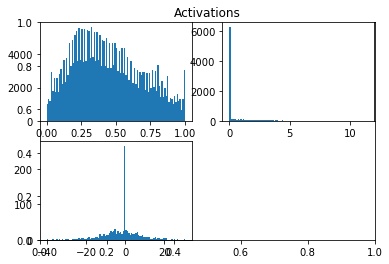

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[  0   0 100]
[2 2 2 ..., 2 2 2]
[   0    0 5000]
cost: 140.2987739105449, train accuracy: 0.14, validation accuracy: 0.0954
iterations finished: 1 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.000416128432199 SD 0.0255751971756
Weights 1 Mean -0.00157120820023 SD 0.139278752579


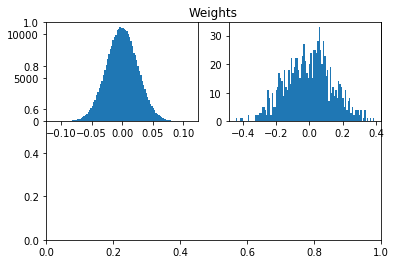

dW 0 Mean 0.43422303588 SD 1.92841302862
dW 1 Mean -2.3385791792e-10 SD 22.8886808653


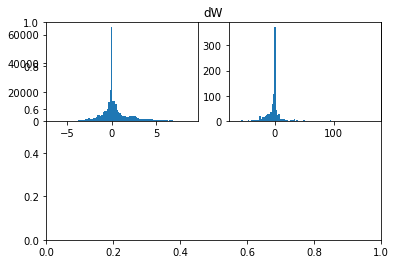

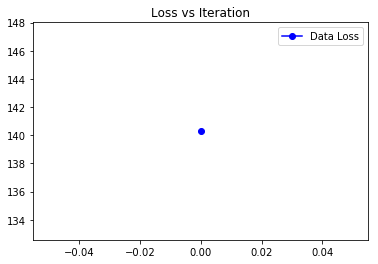

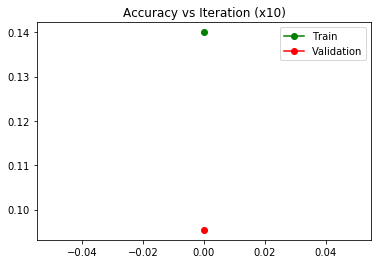

[0 0 0 0 0 0 7 0 0 0 0 6 0 9 0 0 0 0 0 0 0 8 0 0 0 0 0 0 8 8 0 9 0 8 0 0 0
 0 0 0 0 0 0 0 0 0 0 9 6 1 0 0 0 0 4 0 0 0 0 0 0 0 0 0 8 0 0 0 6 0 0 0 0 0
 9 0 0 0 9 0 0 0 0 0 0 0 0 0 3 9 0 6 0 0 6 0 0 9 0 0]
[79  1  0  1  1  0  5  1  5  7]
[0 0 8 ..., 0 0 0]
[4081   17    5   67  113   10  152   10  173  372]
cost: 23.186610873333247, train accuracy: 0.18, validation accuracy: 0.1214
iterations finished: 11 alpha: 0.001 reg. lambda: 0.0


[4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4
 4 4 0 4 9 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 0 4 9 4 3 4 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 0 4 4 0 4 4 9 4 4 4 4 4 4 4 4 9]
[ 7  0  0  1 86  0  1  0  0  5]
[4 4 4 ..., 4 4 4]
[ 507    4    2  138 4083    3   22    3    5  233]
cost: 23.28611607498573, train accuracy: 0.13, validation accuracy: 0.1172
iterations finished: 21 alpha: 0.001 reg. lambda: 0.0


[0 0 0 0 0 0 0 0 3 0 0 0 9 0 0 0 0 0 0 0 9 0 0 4 0 0 0 0 0 0 0 4 0 0 0 3 0
 9 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

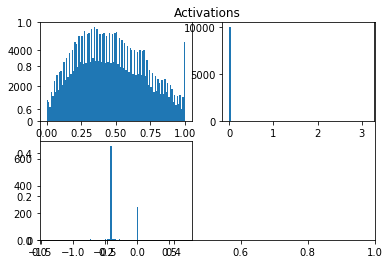

[0 0 8 0 8 0 0 0 0 0 0 0 0 0 8 6 0 0 8 0 0 0 0 0 0 6 8 0 0 0 0 0 0 0 0 0 0
 8 8 0 0 0 0 0 8 0 0 0 0 8 8 0 0 0 8 0 0 0 0 0 0 8 0 0 8 8 0 8 0 0 0 8 0 8
 6 0 8 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0]
[77  0  0  0  0  0  3  0 20]
[0 0 0 ..., 0 0 0]
[3690    2    1    5   18    2  110    5 1131   36]
cost: 23.202240514612058, train accuracy: 0.1, validation accuracy: 0.127
iterations finished: 101 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00205883585082 SD 0.0255607031172
Weights 1 Mean -0.00157120819578 SD 0.162798207775


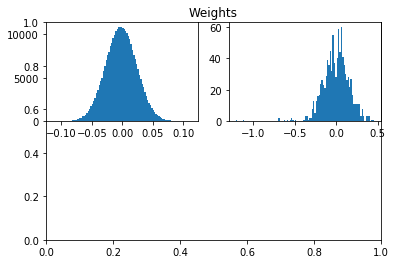

dW 0 Mean -0.00224958799604 SD 0.0261491529048
dW 1 Mean -1.14338689627e-11 SD 0.157191953939


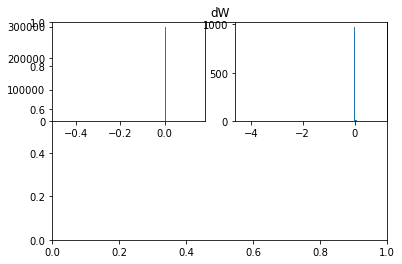

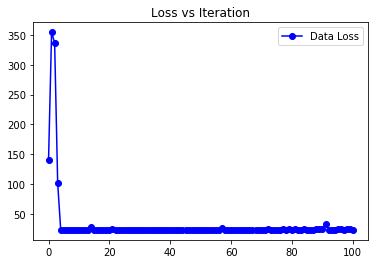

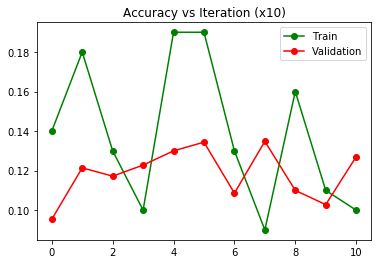

[0 9 9 9 9 9 0 9 9 0 0 9 9 0 9 9 0 9 0 0 9 9 9 0 9 9 9 9 0 0 0 0 0 0 9 0 9
 9 9 9 0 9 9 6 0 0 0 9 9 0 9 0 0 0 9 0 0 9 0 0 9 0 0 9 9 0 0 9 9 9 0 0 0 0
 9 0 0 9 0 9 9 9 0 0 0 6 0 0 0 0 0 0 0 0 9 9 9 0 0 0]
[53  0  0  0  0  0  2  0  0 45]
[0 0 0 ..., 9 0 0]
[2567    2    1   11   16    4   95   11   22 2271]
cost: 24.753281696953593, train accuracy: 0.13, validation accuracy: 0.1182
iterations finished: 111 alpha: 0.001 reg. lambda: 0.0


[8 8 8 8 0 8 0 8 0 8 8 0 8 8 8 0 8 0 8 0 8 0 8 8 0 8 8 0 8 8 8 0 0 0 8 0 8
 8 8 8 8 8 8 0 8 8 8 8 0 0 8 8 8 8 8 8 0 8 0 0 8 8 8 8 9 8 8 8 0 0 8 0 0 0
 8 8 8 0 8 9 8 8 8 8 8 8 8 0 8 8 8 0 8 0 8 0 0 0 0 0]
[34  0  0  0  0  0  0  0 64  2]
[0 8 8 ..., 8 8 0]
[1479    3    1    3   12    1   55    9 3362   75]
cost: 24.413198411711928, train accuracy: 0.11, validation accuracy: 0.1102
iterations finished: 121 alpha: 0.001 reg. lambda: 0.0


[0 0 0 0 9 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 9 0 0 0 0 9 9 0 9 0 0 0 0 0
 9 0 0 0 0 0 0 0 0 9 6 9 0 0 0 0 0 0 0 0 0 9 

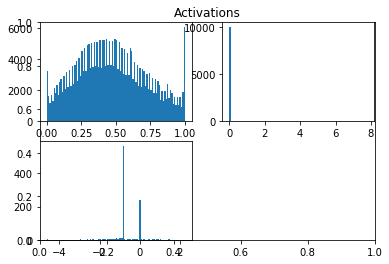

[0 8 8 0 0 0 8 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 8 8 0 0 0 8 0 8 8 0 0 8 0
 0 0 8 0 8 0 8 0 0 0 0 8 0 0 0 8 0 0 0 0 0 0 8 0 8 0 0 8 0 0 0 0 8 0 8 0 8
 8 0 0 0 0 0 0 0 0 8 8 8 8 8 0 0 0 0 8 0 8 0 0 8 8 8]
[68  0  0  0  0  0  0  1 31]
[0 0 0 ..., 8 0 0]
[3529   12    0    7   11    1   20   14 1393   13]
cost: 24.539824203166017, train accuracy: 0.08, validation accuracy: 0.1244
iterations finished: 201 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00206153573824 SD 0.0255632038123
Weights 1 Mean -0.00157120818755 SD 0.162885648852


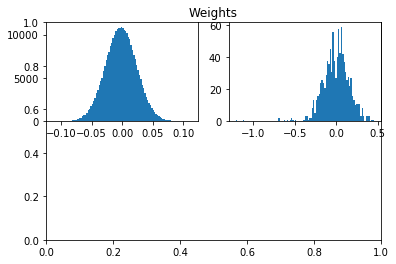

dW 0 Mean 0.00132592368907 SD 0.0148683637955
dW 1 Mean -8.22536825318e-11 SD 0.573847561097


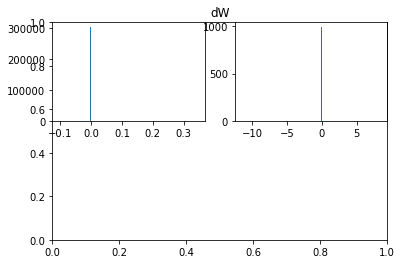

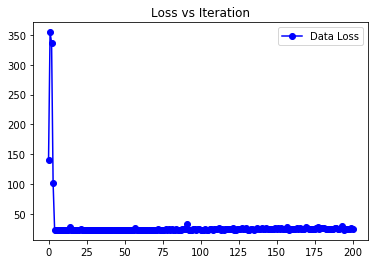

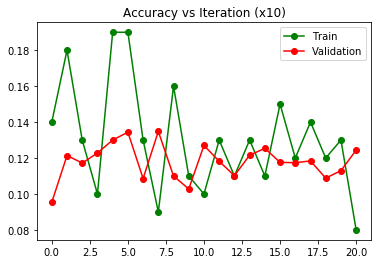

[0 0 8 0 0 0 0 8 0 0 0 0 0 0 8 8 8 8 0 8 8 0 8 9 0 0 0 8 8 0 6 0 8 0 0 0 0
 8 8 8 0 8 0 0 8 0 8 0 8 8 0 0 0 8 8 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 8 0 0 9
 0 8 0 8 8 0 0 8 0 0 8 0 8 0 8 4 0 8 0 0 8 8 0 0 0 8]
[61  0  0  0  1  0  1  0 35  2]
[0 8 0 ..., 8 0 0]
[2828    2    0   21    7    1   20   14 2023   84]
cost: 25.419775011982107, train accuracy: 0.13, validation accuracy: 0.1236
iterations finished: 211 alpha: 0.001 reg. lambda: 0.0


[0 0 8 0 0 8 0 0 0 0 0 0 8 0 8 8 0 8 0 0 0 8 0 8 8 0 0 0 0 8 7 8 0 0 0 0 0
 8 0 0 0 8 0 0 8 0 0 8 8 0 8 0 0 0 0 8 0 0 0 0 0 0 8 8 0 8 8 0 8 0 0 8 0 0
 0 0 0 0 0 0 0 0 8 0 0 0 8 0 0 0 0 0 0 0 8 8 7 8 0 8]
[68  0  0  0  0  0  0  2 30]
[0 0 0 ..., 8 0 0]
[3426    1    0    2    7    0   18   37 1505    4]
cost: 24.631968044408847, train accuracy: 0.11, validation accuracy: 0.1256
iterations finished: 221 alpha: 0.001 reg. lambda: 0.0


[8 0 0 6 8 0 0 8 8 0 8 0 9 8 0 0 0 8 8 0 0 8 0 0 0 8 0 0 0 8 8 8 8 0 8 8 8
 8 8 0 0 8 0 0 0 8 8 8 0 8 8 8 8 8 8 0 8 0 8 8 0

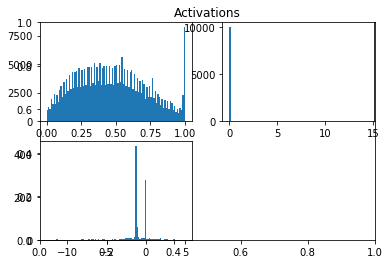

[8 0 8 0 8 0 8 0 0 0 0 8 0 0 0 0 8 0 0 0 0 0 8 0 0 8 8 0 0 0 0 0 0 0 0 8 0
 0 8 0 8 0 0 0 8 0 8 8 0 0 0 0 8 0 8 0 0 0 0 0 8 8 0 8 0 0 0 8 8 8 8 0 0 0
 8 8 0 0 0 8 0 0 8 8 0 0 0 8 0 8 8 8 8 8 0 0 0 8 8 0]
[63  0  0  0  0  0  0  0 37]
[0 0 0 ..., 8 0 0]
[3146    0    0    1    4    1    4    8 1836]
cost: 28.385400836899944, train accuracy: 0.17, validation accuracy: 0.1212
iterations finished: 301 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00206130785845 SD 0.0255657788138
Weights 1 Mean -0.00157120817663 SD 0.163012934433


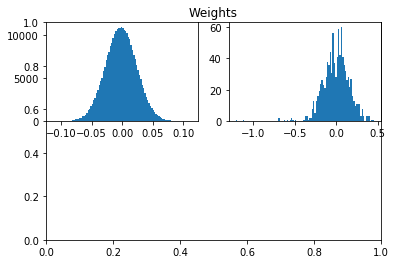

dW 0 Mean 0.00337836971952 SD 0.0363604493391
dW 1 Mean -1.44957208903e-10 SD 0.60410186952


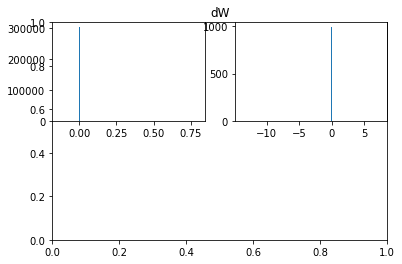

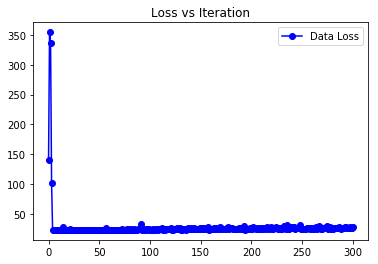

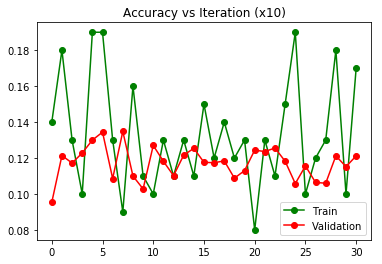

[9 0 0 9 0 0 9 0 0 0 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 9 9 9 0 0 9 0 9 9 9 9
 9 0 9 9 9 0 9 0 0 9 9 9 9 0 0 0 9 9 9 9 0 0 9 9 9 0 9 0 9 0 9 9 9 9 0 0 9
 0 0 0 9 0 0 0 0 9 0 0 0 0 0 0 0 9 9 9 9 0 0 0 0 9 9]
[44  0  0  0  0  0  0  0  0 56]
[0 9 9 ..., 9 0 0]
[2481    0    0    0    3    1    3   12    1 2499]
cost: 26.383834718996916, train accuracy: 0.14, validation accuracy: 0.1038
iterations finished: 311 alpha: 0.001 reg. lambda: 0.0


[0 0 8 8 0 8 8 8 8 8 8 8 8 0 0 0 0 8 0 8 8 0 8 8 0 0 8 8 0 8 0 8 0 0 8 8 8
 8 8 0 8 0 8 8 8 0 8 0 8 0 8 8 0 0 0 0 0 8 0 8 0 8 8 0 8 8 8 8 8 8 8 0 8 8
 0 0 8 8 0 0 0 8 8 8 0 8 0 8 0 8 8 8 8 0 8 8 8 8 8 0]
[39  0  0  0  0  0  0  0 61]
[0 8 8 ..., 8 8 0]
[2001    0    0    0    3    0    3   20 2968    5]
cost: 26.86059788635704, train accuracy: 0.12, validation accuracy: 0.109
iterations finished: 321 alpha: 0.001 reg. lambda: 0.0


[8 8 0 0 8 0 8 0 8 0 8 0 8 0 7 8 8 8 8 8 8 0 8 0 8 8 0 0 8 0 8 8 0 0 8 8 0
 8 0 0 0 0 0 0 0 8 8 8 0 0 8 8 0 8 0 8 0 0 8 0 0 0

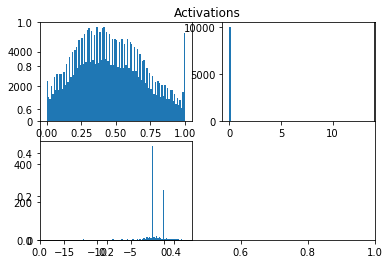

[0 9 9 9 0 0 9 0 0 0 3 0 9 0 3 9 9 9 0 9 9 0 9 9 9 9 9 0 9 9 9 0 0 0 9 0 0
 9 0 9 9 9 9 9 9 9 9 9 0 9 9 9 9 0 9 9 7 0 9 0 9 0 9 9 0 0 9 9 0 0 9 0 0 0
 9 0 0 9 9 0 0 9 0 9 9 9 9 0 9 0 9 3 9 9 9 0 9 9 0 0]
[39  0  0  3  0  0  0  1  0 57]
[0 9 9 ..., 9 0 0]
[2393    0    0  159    1    0    3   33    1 2410]
cost: 29.063874094896082, train accuracy: 0.16, validation accuracy: 0.1048
iterations finished: 401 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00205213689729 SD 0.0255697291278
Weights 1 Mean -0.00157120816662 SD 0.163189005145


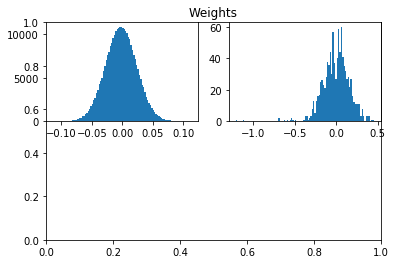

dW 0 Mean -0.00466369377336 SD 0.035435374031
dW 1 Mean -1.68666744571e-10 SD 1.27573404953


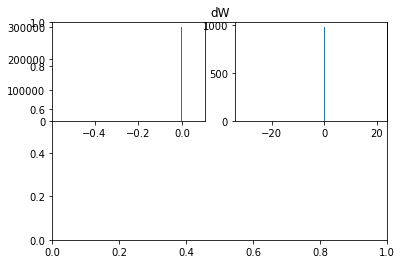

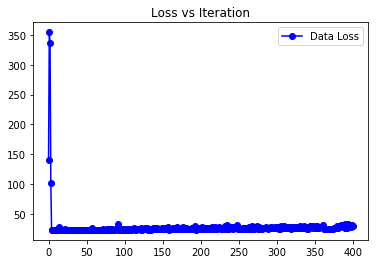

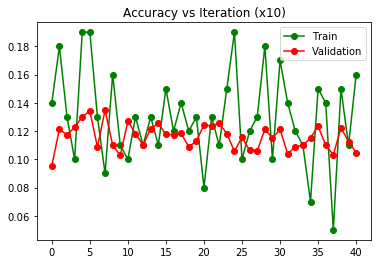

[0 8 0 0 0 0 9 8 0 0 0 8 9 0 0 0 8 8 0 0 0 8 8 0 8 0 8 8 0 8 8 0 0 8 0 0 8
 0 8 9 0 0 0 0 9 8 0 0 8 0 0 8 8 8 0 0 0 9 0 8 8 0 0 0 0 0 8 0 0 0 0 8 0 8
 8 8 0 0 0 8 0 8 0 0 0 0 8 8 0 0 0 0 8 0 0 7 0 8 8 0]
[60  0  0  0  0  0  0  1 34  5]
[0 8 0 ..., 8 0 0]
[2824    0    0   37    1    1    2  105 1722  308]
cost: 28.499661633566785, train accuracy: 0.09, validation accuracy: 0.1322
iterations finished: 411 alpha: 0.001 reg. lambda: 0.0


[8 8 8 0 8 8 8 8 8 8 8 8 0 8 0 8 8 8 0 8 8 0 0 8 8 0 8 0 9 0 8 0 8 8 8 8 8
 0 0 0 8 8 0 8 0 0 0 0 0 8 8 0 8 0 8 0 0 8 8 0 0 8 8 8 0 0 0 0 8 8 0 0 8 8
 8 8 0 8 8 8 8 0 8 0 0 0 8 8 8 0 0 8 8 9 8 8 8 0 8 8]
[39  0  0  0  0  0  0  0 59  2]
[0 8 8 ..., 8 8 0]
[2132    0    0    5    1    0    2   12 2776   72]
cost: 27.82345577761481, train accuracy: 0.11, validation accuracy: 0.1146
iterations finished: 421 alpha: 0.001 reg. lambda: 0.0


[0 8 0 0 0 0 0 0 0 0 8 0 8 9 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 8 3 9 0 9 0 0
 0 0 8 0 0 0 0 0 0 0 0 8 0 0 0 8 8 3 0 0 0 0 0

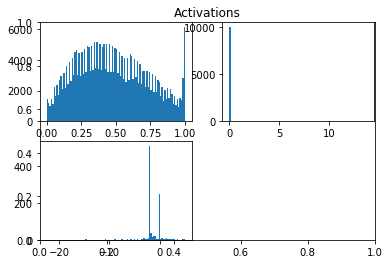

[8 0 8 0 9 0 0 0 8 3 3 0 0 9 0 0 0 8 0 8 8 0 0 0 0 0 8 0 0 0 0 9 8 0 3 0 3
 8 0 9 0 8 8 0 8 0 9 0 0 9 0 0 8 9 9 9 3 8 0 9 9 0 3 0 0 9 3 9 0 8 9 0 0 0
 9 0 9 0 0 0 0 9 8 9 0 9 3 8 8 0 0 0 0 9 0 8 8 0 9 0]
[51  0  0  8  0  0  0  0 20 21]
[0 8 9 ..., 8 0 0]
[2497    0    0  289    1    0    2   13 1196 1002]
cost: 31.176492080750403, train accuracy: 0.19, validation accuracy: 0.128
iterations finished: 501 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00205176260689 SD 0.0255718756146
Weights 1 Mean -0.00157120815237 SD 0.163437211952


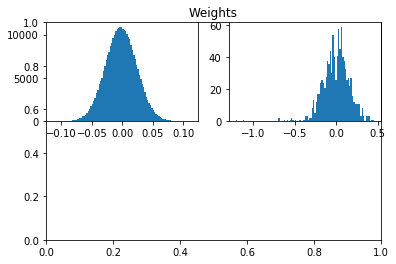

dW 0 Mean -0.00289513805007 SD 0.0349253670738
dW 1 Mean -1.60617936729e-10 SD 1.34534426437


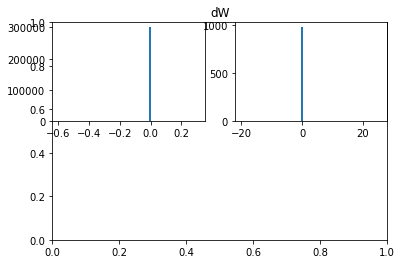

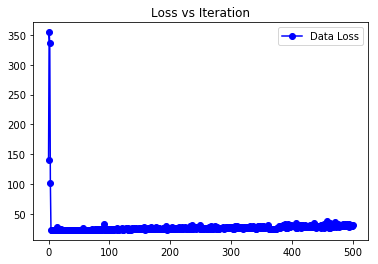

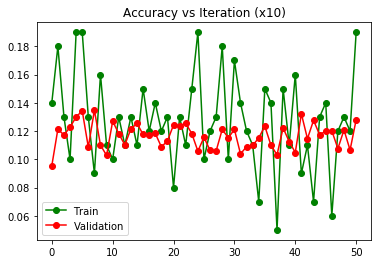

[0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0
 1 0 1 0 0 0 0 1 6 1 1 0 0 0 3 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
[66 32  0  1  0  0  1]
[0 0 0 ..., 0 0 0]
[3420 1499    0   64    1    0    2   13    1]
cost: 33.63545997310268, train accuracy: 0.15, validation accuracy: 0.1056
iterations finished: 511 alpha: 0.0009000000000000001 reg. lambda: 0.0


[8 8 0 0 0 0 0 0 8 0 0 0 0 0 8 0 8 0 0 0 8 8 0 0 0 8 8 8 8 0 0 8 0 8 0 0 8
 8 8 0 0 8 0 0 0 0 0 0 0 8 8 0 0 0 8 8 0 0 0 0 8 8 8 0 0 8 8 0 0 0 0 8 0 0
 0 8 0 0 8 8 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 8 0 0 8 0]
[67  0  0  0  0  0  0  0 33]
[0 8 0 ..., 8 0 0]
[2907    0    0    4    1    0    2   20 2061    5]
cost: 28.275309565766392, train accuracy: 0.11, validation accuracy: 0.1192
iterations finished: 521 alpha: 0.0009000000000000001 reg. lambda: 0.0


[9 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 9 0 0 0 0 0 0 0 0 0 9 0 9 0 0 0
 0 0 0 0 9 0 9 0 0 9 0 0 9 9 0 

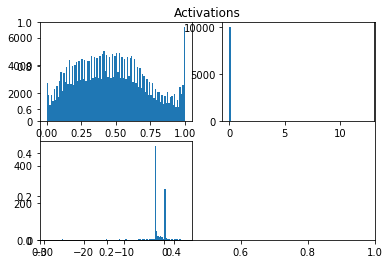

[0 0 8 0 0 8 8 0 8 0 0 8 8 8 8 0 8 0 8 0 0 8 0 8 0 0 0 8 0 8 0 8 0 0 0 0 0
 0 8 8 0 8 0 0 0 8 0 0 8 0 0 0 0 0 8 8 0 0 0 9 8 0 0 8 0 0 0 0 0 0 8 8 0 8
 0 0 8 9 8 0 0 8 8 8 8 0 0 0 0 8 8 8 0 8 8 8 0 8 8 0]
[57  0  0  0  0  0  0  0 41  2]
[0 0 0 ..., 8 0 0]
[3058    0    0    0    0    0    1   62 1786   93]
cost: 32.81871724895832, train accuracy: 0.14, validation accuracy: 0.1282
iterations finished: 601 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00205750010589 SD 0.0255745227766
Weights 1 Mean -0.00157120813644 SD 0.16375904578


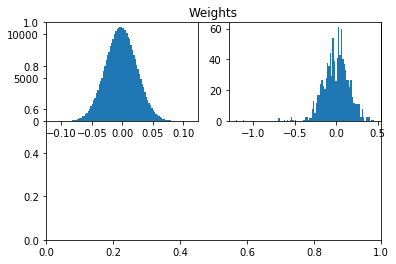

dW 0 Mean 0.000423363834122 SD 0.0200936994092
dW 1 Mean -1.70168462432e-10 SD 1.28847218598


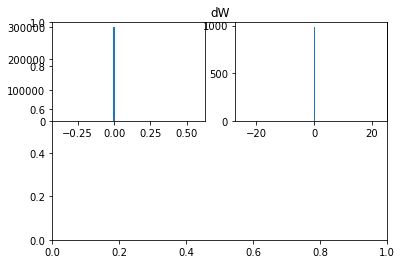

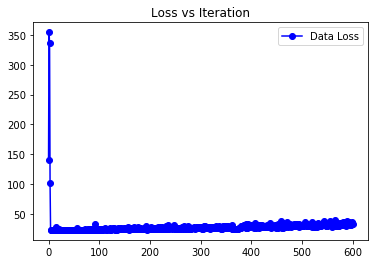

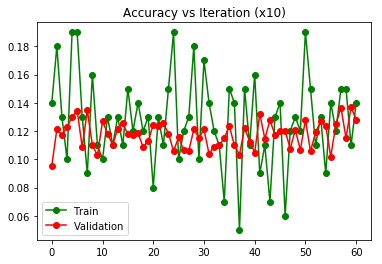

[9 9 9 9 0 0 9 8 0 9 0 9 9 0 0 9 9 0 0 9 0 0 0 0 9 8 9 0 0 9 9 0 9 9 9 0 9
 9 9 9 8 9 9 0 9 0 9 0 0 9 9 9 0 0 9 9 9 0 0 9 0 0 9 0 0 0 9 9 9 0 9 0 0 8
 0 9 0 9 0 0 9 9 9 0 0 0 1 0 8 0 0 0 7 0 0 9 8 9 0 9]
[46  1  0  0  0  0  0  1  6 46]
[0 0 9 ..., 9 0 0]
[2201   71    0    0    0    0    1   10  318 2399]
cost: 29.64241138357599, train accuracy: 0.12, validation accuracy: 0.118
iterations finished: 611 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 0 0 9 0 9 0 9 0 0 0 0 0 0 9 0 0 0 8 0 0 0 8 0 8 0 0 9 0 0 8 9 0 0 9 0 8
 0 9 0 0 9 8 0 0 0 9 9 0 0 0 8 8 0 0 0 0 8 8 0 0 9 0 0 0 9 0 0 0 0 0 0 0 9
 0 0 0 8 0 0 0 0 0 8 8 9 8 8 9 8 0 0 0 8 0 0 0 9 9 0]
[65  0  0  0  0  0  0  0 17 18]
[0 0 0 ..., 8 0 0]
[3003    0    0    0    0    0    1   13 1045  938]
cost: 32.066154075422254, train accuracy: 0.14, validation accuracy: 0.1414
iterations finished: 621 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 9 0 9 0 7 0 0 0 0 9 0 0 0 0 0 0 0 0 0 9 0
 0 0 0 0 0 0 0 

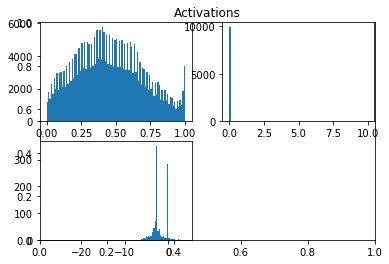

[0 0 0 0 0 1 9 9 0 0 0 9 9 9 0 0 9 0 1 9 0 0 0 0 0 0 9 0 9 0 0 0 0 0 9 0 9
 7 9 0 0 0 0 0 0 9 9 9 9 0 0 0 0 0 0 0 0 0 9 0 0 0 9 0 0 0 0 0 1 9 0 0 9 0
 0 0 9 0 9 0 0 9 9 0 0 0 0 9 0 0 0 9 0 0 9 0 0 0 0 9]
[68  3  0  0  0  0  0  1  0 28]
[0 0 9 ..., 0 0 0]
[3310  273    0    0    0    0    1   35    0 1381]
cost: 33.12692016552154, train accuracy: 0.13, validation accuracy: 0.1364
iterations finished: 701 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00205328853705 SD 0.0255798414215
Weights 1 Mean -0.00157120811496 SD 0.163954197075


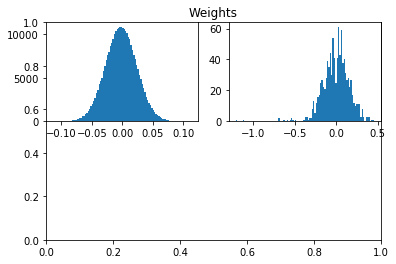

dW 0 Mean 0.00534826783447 SD 0.129579459424
dW 1 Mean -3.48955401464e-10 SD 1.19285752543


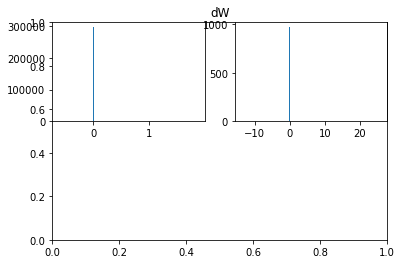

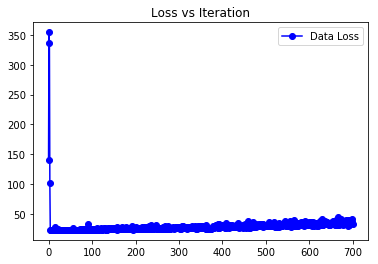

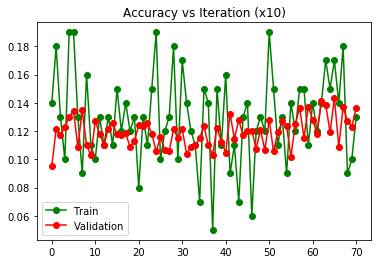

[0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 9
 0 0 0 0 0 0 0 9 9 0 0 0 0 0 0 0 9 0 0 0 0 0 9 0 9 9 0 0 9 9 0 0 0 0 0 0 9
 9 9 0 0 9 9 9 0 9 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 9 0]
[79  0  0  0  0  0  0  0  0 21]
[0 0 0 ..., 0 0 0]
[4057    0    0    0    0    0    1   36    0  906]
cost: 38.65722480993416, train accuracy: 0.18, validation accuracy: 0.138
iterations finished: 711 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[96  0  0  0  0  0  0  1  0  3]
[0 0 0 ..., 0 0 0]
[4735    0    0    0    0    0    0   55    0  210]
cost: 33.570468599984345, train accuracy: 0.15, validation accuracy: 0.1178
iterations finished: 721 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 8 8 0 8 0 9 8 9 8 8 0 7 9 8 9 9 8 9 9 8 8 8 9 8 0 8 9 8 0 0 8 8 0 8 8 8
 8 8 0 8 8 0 8 

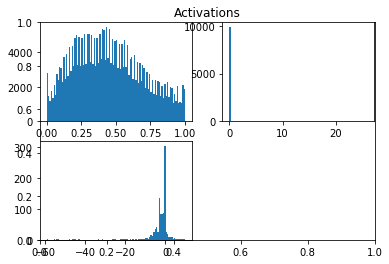

[5 5 0 0 9 5 5 0 0 5 3 0 5 0 5 5 5 5 0 0 0 0 5 5 0 0 3 9 0 5 5 5 0 0 5 5 0
 5 0 5 9 5 5 5 3 5 5 0 0 5 0 5 0 5 5 0 0 5 3 0 3 0 0 5 0 0 0 5 0 5 0 0 5 5
 5 5 5 0 5 0 5 5 0 5 5 0 3 0 0 5 5 5 5 5 5 5 5 0 5 5]
[39  0  0  6  0 52  0  0  0  3]
[5 0 5 ..., 0 5 5]
[2082    0    0  428    0 2199    0   53    0  238]
cost: 43.918378593623224, train accuracy: 0.19, validation accuracy: 0.1692
iterations finished: 801 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00203036259036 SD 0.0255892117111
Weights 1 Mean -0.00157120807128 SD 0.164544612609


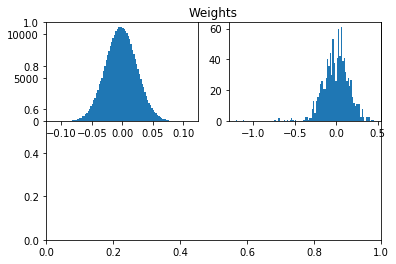

dW 0 Mean 0.00867346344234 SD 0.065445145587
dW 1 Mean -1.0330038549e-09 SD 2.82905552791


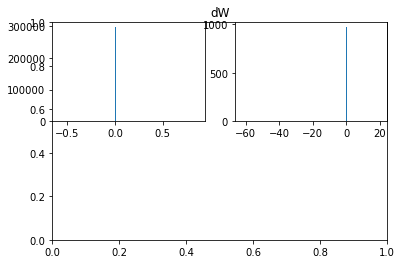

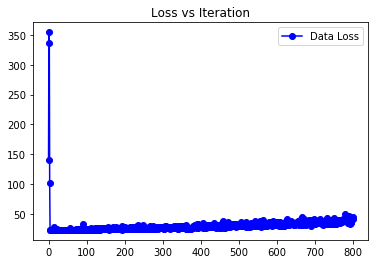

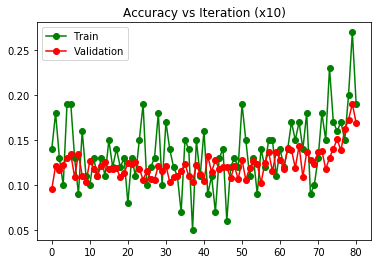

[3 9 0 9 0 0 3 9 8 8 8 0 8 3 3 3 8 3 8 9 0 8 8 9 9 8 0 0 0 0 0 0 0 8 8 3 3
 0 3 3 3 8 0 9 3 0 3 3 8 3 0 3 0 3 8 8 0 9 0 8 8 8 9 0 3 8 0 3 3 9 0 9 3 8
 9 0 9 3 3 0 3 9 8 0 8 8 9 8 8 3 0 8 0 3 8 3 0 9 0 0]
[30  0  0 27  0  0  0  0 27 16]
[3 8 0 ..., 8 3 0]
[1396    0    0 1488    0    1    0    8 1137  970]
cost: 47.75003511118512, train accuracy: 0.15, validation accuracy: 0.18
iterations finished: 811 alpha: 0.0009000000000000001 reg. lambda: 0.0


[5 5 0 0 5 9 5 0 9 3 9 9 9 0 0 0 0 0 9 5 0 0 0 9 9 9 9 9 9 9 9 0 5 5 9 9 9
 9 5 5 9 0 0 0 5 0 0 9 0 5 5 9 9 9 9 0 5 5 0 0 5 5 5 9 9 5 9 5 9 9 0 9 0 0
 9 0 9 5 5 9 5 0 9 9 5 9 0 9 9 9 9 0 0 9 9 9 0 0 9 0]
[32  0  0  1  0 23  0  0  0 44]
[5 0 9 ..., 9 5 0]
[1633    0    3    2    0 1187    0   14    0 2161]
cost: 45.14064571985855, train accuracy: 0.14, validation accuracy: 0.149
iterations finished: 821 alpha: 0.0009000000000000001 reg. lambda: 0.0


[9 6 7 6 6 6 6 6 6 6 0 6 6 6 6 6 7 6 9 6 6 6 7 9 6 7 6 6 6 6 6 7 6 9 7 6 7
 6 6 6 6 9 6 9 7 6

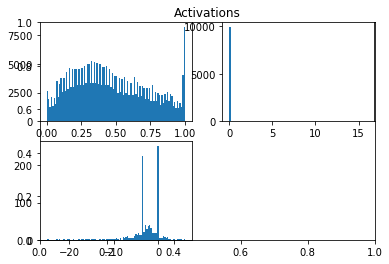

[9 0 2 0 2 0 2 0 2 0 9 0 2 9 9 2 2 0 9 0 2 9 2 0 2 9 0 0 2 0 9 2 9 2 9 9 0
 9 9 2 9 2 9 2 9 0 2 9 0 2 1 9 9 9 0 2 2 0 2 2 9 2 2 2 9 9 9 9 9 2 0 2 9 0
 2 2 0 0 0 2 9 0 0 2 2 2 0 0 9 0 0 9 0 9 9 0 9 0 9 0]
[32  1 33  0  0  0  0  0  0 34]
[2 0 0 ..., 9 2 2]
[1459    3 1922    8    0    0    0    7    0 1601]
cost: 42.50677360602205, train accuracy: 0.2, validation accuracy: 0.1572
iterations finished: 901 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00206507706262 SD 0.0255997422676
Weights 1 Mean -0.00157120800468 SD 0.165569926804


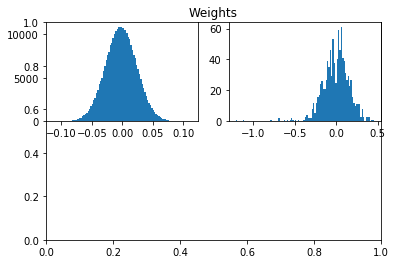

dW 0 Mean 0.00695844458324 SD 0.0705148841617
dW 1 Mean -7.05143996527e-10 SD 3.15557683038


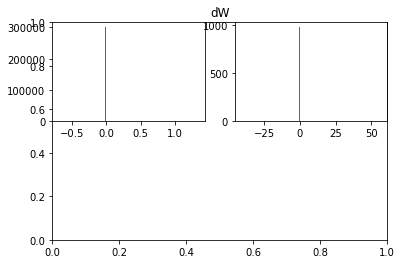

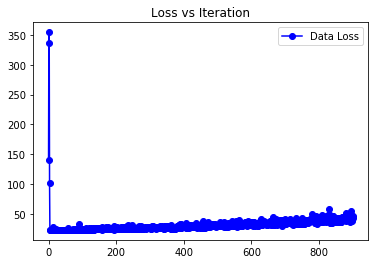

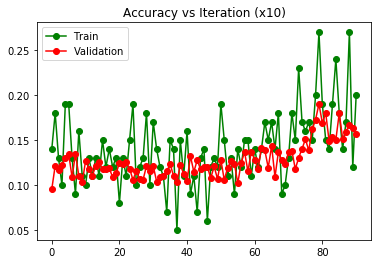

[8 2 2 8 8 2 2 8 2 0 2 8 2 2 0 8 8 8 2 8 2 0 8 8 0 2 2 2 0 2 0 8 8 2 0 8 2
 0 2 2 8 8 0 8 2 2 2 2 0 2 2 8 8 2 2 0 0 0 8 0 2 0 2 8 8 2 8 8 8 2 8 2 8 2
 0 8 1 2 8 2 8 2 8 2 2 2 8 8 2 8 2 8 8 2 2 2 8 8 8 8]
[16  1 43  0  0  0  0  0 40]
[2 0 8 ..., 8 2 2]
[ 717   48 1945    0    0    0    1   90 2199]
cost: 44.02655035413412, train accuracy: 0.17, validation accuracy: 0.156
iterations finished: 911 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 4 0 0 4 4 4 4 0 4 0 0 0 4 0 0 4 0 0 0 0 0 4 0 0 0 4 0 0 4 4 4 0 4 0 4 0
 0 0 0 4 0 0 0 4 4 4 4 4 0 0 4 4 4 0 0 4 4 0 4 0 4 0 0 4 0 4 4 0 0 0 4 4 4
 4 0 4 0 0 0 4 4 4 4 0 4 4 0 0 0 0 0 0 0 4 4 0 0 0 4]
[55  0  0  0 45]
[4 0 0 ..., 0 4 4]
[2773    7    0    0 2220]
cost: 40.23967481168159, train accuracy: 0.27, validation accuracy: 0.1588
iterations finished: 921 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 0 0 6 6 0 6 6 6 0 0 7 0 6 0 6 6 0 6 6 6 7 0 6 7 0 0 6 0 0 6 6 2 6 0 0 6
 0 0 0 0 0 0 0 0 6 6 0 0 6 6 0 0 0 6 6 0 0 0 0 6 0 0 0 6 0 6 6 6

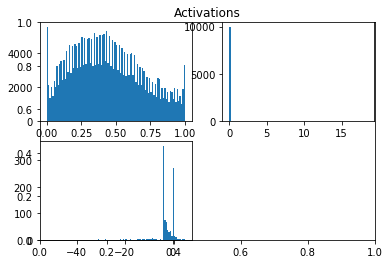

[3 3 3 3 9 3 3 9 9 3 3 9 3 3 3 3 0 9 3 3 9 3 3 9 3 3 3 3 9 3 9 0 3 3 9 3 0
 0 9 0 9 0 3 3 3 9 9 0 0 3 9 9 9 9 9 9 9 9 3 3 9 9 3 3 9 3 0 0 3 9 3 3 9 9
 9 9 0 9 9 3 3 9 3 9 3 3 3 3 3 3 3 9 3 9 0 3 3 9 3 3]
[12  0  0 51  0  0  0  0  0 37]
[3 0 0 ..., 0 3 3]
[ 532    0    0 2569    0    0    0    0    0 1899]
cost: 42.53006274399851, train accuracy: 0.22, validation accuracy: 0.1572
iterations finished: 1001 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00205332449297 SD 0.0256162326412
Weights 1 Mean -0.0015712079396 SD 0.167030563863


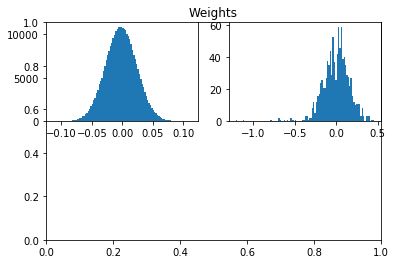

dW 0 Mean -0.010094007016 SD 0.0695744777172
dW 1 Mean -5.77414468239e-10 SD 1.83174282374


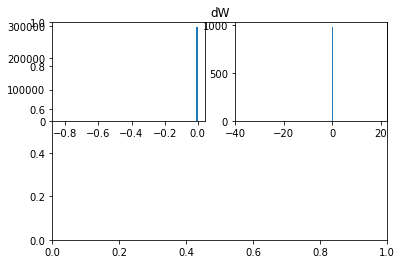

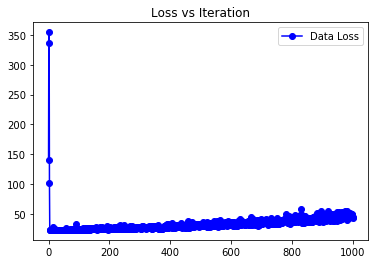

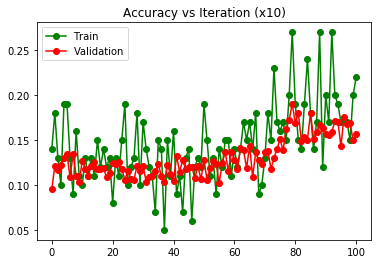

[8 6 6 0 8 6 8 6 6 8 6 8 6 6 6 6 6 3 8 8 0 8 6 6 6 6 6 6 6 8 6 6 8 3 8 3 8
 6 8 6 6 8 6 3 8 6 8 8 8 8 6 8 6 8 8 6 8 6 8 8 8 6 8 6 6 6 8 6 8 3 6 8 6 6
 8 6 6 6 6 8 6 6 6 8 6 6 6 6 6 6 8 6 6 6 0 6 6 8 6 8]
[ 3  0  0  5  0  0 56  0 36]
[6 0 3 ..., 1 6 6]
[ 239   92    0  267    0    0 2624    0 1778]
cost: 45.477122721121276, train accuracy: 0.2, validation accuracy: 0.1856
iterations finished: 1011 alpha: 0.0008100000000000001 reg. lambda: 0.0


[9 4 4 0 4 4 9 9 4 4 9 4 4 4 4 4 9 9 0 9 0 0 4 0 4 4 0 4 0 4 4 4 4 4 4 4 4
 9 4 9 4 4 9 0 0 0 9 4 4 4 4 0 4 4 4 4 4 0 4 9 9 0 4 4 4 9 4 9 4 4 4 4 0 4
 4 9 4 9 4 4 4 4 4 4 4 9 4 4 9 9 9 0 9 9 4 4 4 9 4 0]
[16  0  0  0 60  0  0  0  0 24]
[4 0 4 ..., 9 4 4]
[1201    0    0    0 2648    0    0   13    0 1138]
cost: 51.99749257214129, train accuracy: 0.18, validation accuracy: 0.1772
iterations finished: 1021 alpha: 0.0008100000000000001 reg. lambda: 0.0


[4 8 1 8 1 9 0 4 9 9 4 4 4 9 4 9 9 1 8 9 4 4 4 1 4 8 1 1 4 9 1 8 4 4 1 1 9
 4 9 9 4 4 1 1 1 1 0 

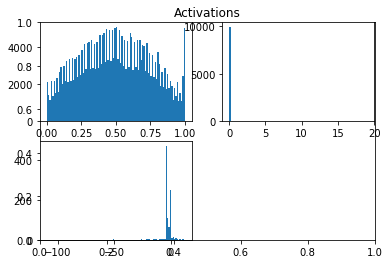

[9 2 9 9 9 9 9 9 9 9 2 2 2 2 2 0 9 9 9 2 9 0 9 2 9 9 9 9 9 9 9 9 9 9 2 9 9
 9 9 0 9 9 9 9 2 2 2 9 0 9 9 9 9 0 0 9 2 0 9 9 9 2 9 0 9 9 9 9 9 9 2 9 9 9
 9 0 9 9 9 9 2 9 9 2 9 9 9 9 9 9 9 9 9 2 9 9 2 9 9 2]
[ 9  0 20  0  0  0  0  0  0 71]
[2 9 9 ..., 9 9 9]
[ 477    0 1071    0    0    9    0   41    0 3402]
cost: 44.97031797794905, train accuracy: 0.12, validation accuracy: 0.1274
iterations finished: 1101 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.0020173193707 SD 0.0256275058893
Weights 1 Mean -0.00157120788264 SD 0.168393654906


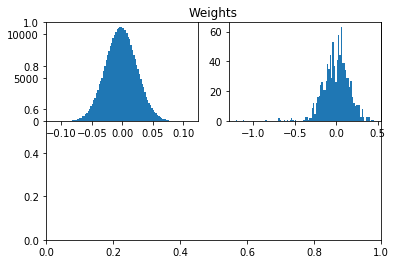

dW 0 Mean -0.0280735475067 SD 0.198168735932
dW 1 Mean -6.34363646057e-10 SD 2.75317879499


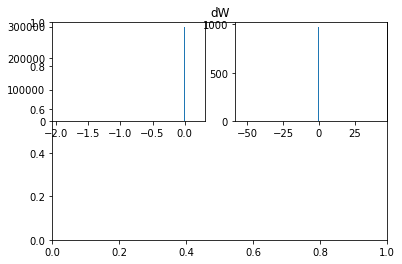

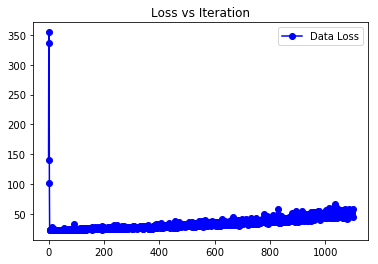

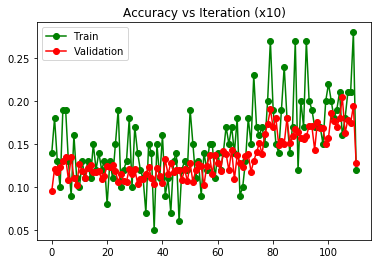

[9 9 9 0 0 1 1 0 1 0 0 0 9 1 1 9 0 0 1 5 9 9 9 9 9 0 9 1 1 9 1 9 1 0 5 0 1
 0 5 0 1 9 1 9 1 1 9 1 9 9 9 9 5 1 0 9 9 1 1 9 9 0 1 9 5 0 0 0 9 9 0 0 1 0
 9 9 0 9 9 0 9 9 5 0 5 9 5 0 9 1 9 9 9 9 1 9 9 0 0 9]
[27 23  0  0  0  8  0  0  0 42]
[5 1 9 ..., 9 9 0]
[1300  891    0    0    0  698    0    0    0 2111]
cost: 54.174390789687315, train accuracy: 0.15, validation accuracy: 0.127
iterations finished: 1111 alpha: 0.0008100000000000001 reg. lambda: 0.0


[5 0 0 0 0 0 5 0 5 0 0 5 0 0 0 0 5 5 0 0 0 0 5 5 0 5 0 5 5 0 0 0 0 0 0 5 0
 0 0 0 5 0 0 5 0 0 5 0 0 0 5 0 5 5 0 5 5 5 0 0 0 0 5 5 0 5 0 5 0 5 5 0 0 0
 0 0 5 0 0 0 0 0 5 0 0 0 0 5 0 0 0 0 5 0 0 0 5 0 0 0]
[68  0  0  0  0 32]
[5 0 0 ..., 0 0 5]
[3121    0    0    0    0 1878    0    1]
cost: 57.57200043524332, train accuracy: 0.21, validation accuracy: 0.1472
iterations finished: 1121 alpha: 0.0008100000000000001 reg. lambda: 0.0


[5 5 5 9 0 0 5 5 5 0 0 0 5 5 0 5 5 5 5 5 0 5 0 5 5 0 0 5 5 5 0 0 5 5 5 5 5
 5 5 5 5 0 5 5 5 0 5 5 5 0 5 0 5 0 

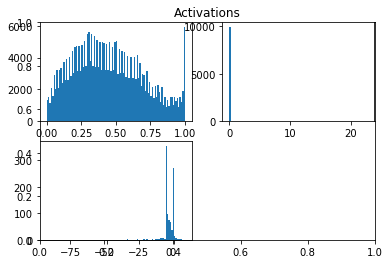

[3 3 0 3 3 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 1 3 3 3 9 3 3 3 3 3 3 8
 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 1 3 8 3 3 3 3 3 3 3 3 3 3 3 3 3 8 3
 0 3 3 0 0 3 3 3 3 9 9 0 3 3 3 3 3 3 3 3 3 3 3 0 3 3]
[10  2  0 82  0  0  0  0  3  3]
[3 3 3 ..., 3 3 3]
[ 411   58    1 4001    0    0    0    0   60  469]
cost: 46.919106900457734, train accuracy: 0.19, validation accuracy: 0.1464
iterations finished: 1201 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00203326242741 SD 0.0256437546481
Weights 1 Mean -0.00157120783273 SD 0.169398560179


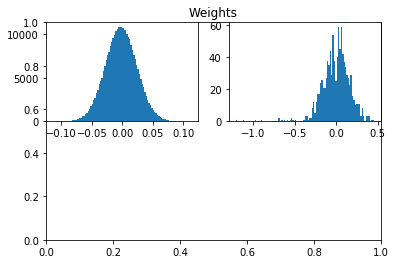

dW 0 Mean -0.0270506329492 SD 0.222663500354
dW 1 Mean -5.9171843958e-10 SD 2.02866513319


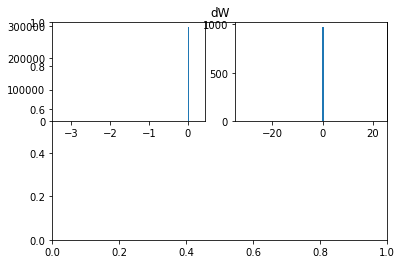

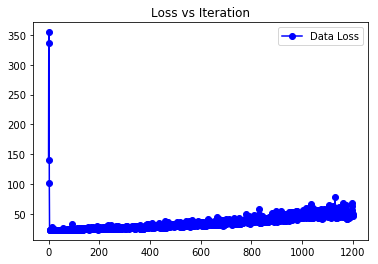

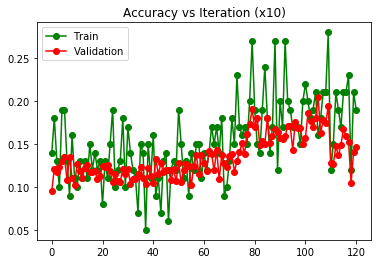

[4 7 8 8 8 8 8 8 8 8 6 7 8 6 6 8 4 1 6 8 8 8 6 7 8 8 6 1 6 8 7 7 6 6 6 6 8
 6 8 8 8 7 8 6 7 6 8 8 6 8 8 6 8 6 6 7 6 8 6 8 6 8 0 8 7 8 7 6 8 6 6 8 4 4
 8 6 6 8 6 0 6 8 8 6 7 8 8 6 8 6 6 6 8 8 6 6 6 1 8 6]
[ 2  3  0  0  4  0 37 11 43]
[6 8 1 ..., 8 6 6]
[ 124  155    0    0  268    0 2055  194 2204]
cost: 55.483307439100344, train accuracy: 0.2, validation accuracy: 0.1864
iterations finished: 1211 alpha: 0.0008100000000000001 reg. lambda: 0.0


[7 7 7 2 7 7 2 7 2 2 2 2 7 7 7 7 7 7 2 7 2 2 7 2 7 2 2 2 2 2 2 2 2 2 2 2 7
 2 7 7 7 7 2 7 2 2 7 7 2 2 2 7 7 2 7 2 2 7 2 7 7 2 2 7 2 2 2 7 2 2 2 2 7 2
 2 2 7 7 2 7 2 2 2 2 7 2 2 7 2 2 7 2 2 2 7 2 2 7 7 7]
[ 0  0 58  0  0  0  0 42]
[2 2 2 ..., 7 2 2]
[  20    0 2963    5    0    0    0 1996    0   16]
cost: 55.46445989583428, train accuracy: 0.1, validation accuracy: 0.0992
iterations finished: 1221 alpha: 0.0008100000000000001 reg. lambda: 0.0


[8 8 5 1 5 1 1 5 5 8 8 5 8 1 8 8 2 5 5 5 1 5 5 5 5 5 5 2 8 2 2 8 1 2 5 5 8
 1 2 5 8 2 8 5 1 5 8 8 1 8 1

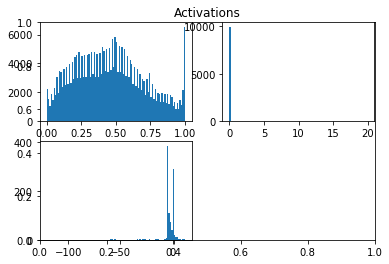

[6 6 8 6 6 6 8 8 8 6 8 6 4 8 6 6 6 6 8 6 8 8 8 6 8 8 8 0 6 6 6 6 9 8 6 8 8
 0 6 8 0 6 8 8 6 8 6 6 6 0 6 6 8 6 6 6 8 8 8 6 6 6 6 6 8 6 8 8 8 8 8 0 8 6
 6 8 8 8 8 8 6 8 6 8 6 8 8 6 6 6 6 0 8 0 8 8 6 6 6 8]
[ 7  0  0  0  1  0 47  0 44  1]
[6 8 6 ..., 8 6 6]
[ 356   10    0    0  140   20 2418    0 2009   47]
cost: 48.97550237162853, train accuracy: 0.14, validation accuracy: 0.1912
iterations finished: 1301 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00203173701336 SD 0.0256531709092
Weights 1 Mean -0.00157120776853 SD 0.171637651375


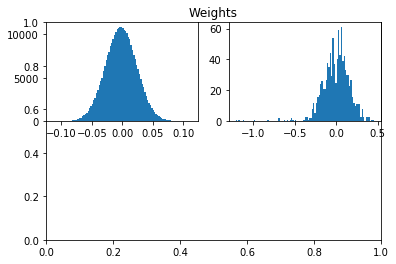

dW 0 Mean -0.0126635847293 SD 0.126189894557
dW 1 Mean -6.15263129333e-10 SD 3.08095704339


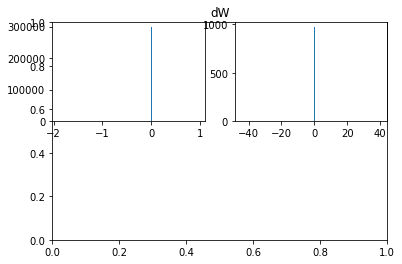

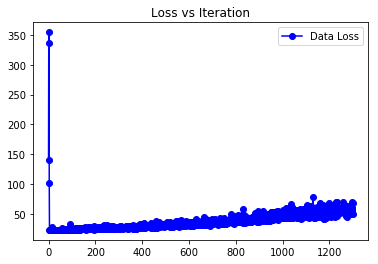

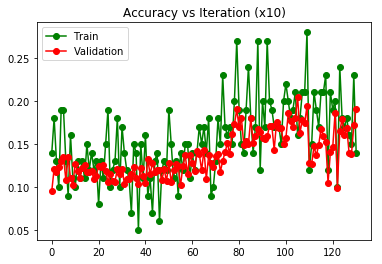

[2 0 0 2 0 2 2 2 2 2 2 2 0 2 1 0 2 2 0 0 2 2 8 8 2 2 2 2 0 2 0 2 2 0 8 0 2
 8 0 0 2 2 8 2 0 0 2 8 8 2 8 8 2 2 2 0 0 2 2 2 8 0 0 2 1 2 0 2 2 2 2 0 0 2
 0 2 0 2 0 0 2 2 2 2 0 8 2 0 8 2 2 2 2 2 2 0 2 2 1 0]
[30  3 55  0  0  0  0  0 12]
[2 2 2 ..., 2 2 2]
[1251   86 3105    0    0    0    0    0  556    2]
cost: 52.788542822935646, train accuracy: 0.22, validation accuracy: 0.1592
iterations finished: 1311 alpha: 0.0008100000000000001 reg. lambda: 0.0


[5 8 5 0 5 5 8 5 5 5 8 5 0 8 5 5 5 5 5 5 8 8 8 8 5 5 0 5 5 5 5 0 5 5 5 5 0
 8 5 5 5 5 5 5 5 5 8 5 0 9 0 5 5 5 5 5 7 5 5 5 7 5 5 5 5 5 5 5 5 5 0 9 5 5
 8 8 5 8 0 1 5 8 5 5 5 8 5 8 5 0 5 0 5 8 5 5 5 9 5 5]
[11  1  0  0  0 66  0  2 17  3]
[5 5 5 ..., 5 5 5]
[ 368    2    0    0    0 3643    0  172  769   46]
cost: 56.76151408793303, train accuracy: 0.18, validation accuracy: 0.1596
iterations finished: 1321 alpha: 0.0008100000000000001 reg. lambda: 0.0


[2 8 8 2 9 8 2 8 8 8 8 2 2 2 2 2 2 8 8 8 8 8 2 8 2 2 8 8 2 8 2 8 8 8 2 8 8
 8 8 8 2 2 2 2 

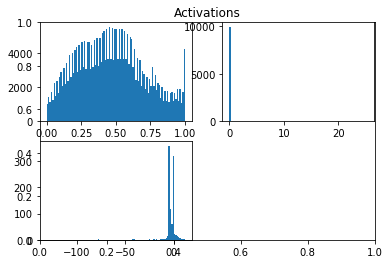

[6 0 4 0 0 0 6 6 4 0 0 6 0 4 6 0 0 0 6 0 0 4 0 0 0 0 0 0 0 6 4 6 0 0 0 0 0
 0 6 0 0 4 6 0 0 4 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 6 0 6 4 4 0 4 0 0
 0 4 0 0 0 4 4 0 0 4 0 0 0 0 4 0 0 6 0 0 4 4 0 0 0 4]
[68  0  0  0 18  0 14]
[6 0 0 ..., 0 0 4]
[3417    0    0    0  864    0  719]
cost: 50.82420721821585, train accuracy: 0.16, validation accuracy: 0.164
iterations finished: 1401 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.0020071446998 SD 0.0256695441882
Weights 1 Mean -0.00157120770486 SD 0.17405349794


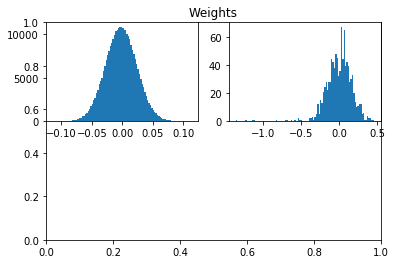

dW 0 Mean -0.0394901906157 SD 0.247186043814
dW 1 Mean -8.44454056903e-10 SD 2.59404841891


KeyboardInterrupt: 

In [74]:
np.random.seed(123456)
layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers
NN2 = NeuralNetwork(layer_dimensions, drop_prob=.25, reg_lambda_L2=.0, \
                    K_iters_alpha_drop=500, gamma=.90, do_reflection=False)
NN2.train(X_train, y_train, iters=5000, alpha=0.001, batch_size=100, print_every=10)#alpha=0.00001